# Installing and Reading in of packages

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.model_selection import train_test_split
import torch

from model_evaluation import get_model_evaluation
from model_extraction import get_model, get_tokenizer, get_pipeline
from model_training import train_model

c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

# Reading in of Data

In [4]:
data = pd.read_csv("data/dataset.csv", header = None, names = ["Label", "Text"])
data = data[['Text', 'Label']]

print(data.head()) # First column: 1 - positive, 0 - negative
print(data.shape)

                                                Text  Label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you sometimes like to go to the movies to h...      1
4  emerges as something rare , an issue movie tha...      1
(10662, 2)


In [5]:
testing_data = pd.read_csv('data/testing_data.csv')

print(testing_data)

                                                   Text  Label
0     this bracingly truthful antidote to hollywood ...      1
1     once the downward spiral comes to pass , auto ...      1
2     bray is completely at sea ; with nothing but a...      0
3     while the production details are lavish , film...      0
4     anyone who suffers through this film deserves ...      0
...                                                 ...    ...
1595  a dream cast of solid female talent who build ...      1
1596  it's an unusual , thoughtful bio-drama with a ...      1
1597  a gorgeous , somnolent show that is splendidly...      0
1598  it's tough to be startled when you're almost d...      0
1599  george lucas returns as a visionary with a tal...      1

[1600 rows x 2 columns]


# Model (Pre-built on Hugging Face)
For a start, we will try a pre-built model on Hugging Face that will analyse the text and give us a rating on whether it is `POSITIVE` or `NEGATIVE`.

In [6]:
sentiment_pipeline = pipeline("sentiment-analysis", model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english") # device = 0
output = sentiment_pipeline(list(testing_data["Text"]))

Device set to use cuda:0


In [7]:
model_predictions = pd.Series(map(lambda x: x['label'], output))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
model_predictions = model_predictions.map(label_mapping)

## Model Evaluation
We will evaluate the model and look at the accuracy of the model.

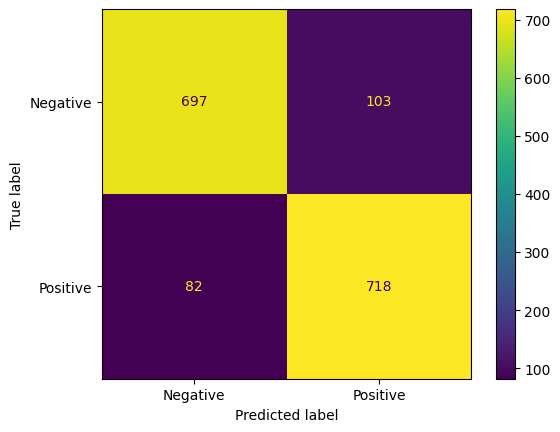

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88       800
    Positive       0.87      0.90      0.89       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

Accuracy: 0.884375
Recall: 0.8975
Precision: 0.8745432399512789
F1-score: 0.8858729179518815


In [8]:
labels = ['Negative', 'Positive']

get_model_evaluation(y_true=testing_data['Label'], y_pred=model_predictions, labels=labels)

# Custom Model
While we see that the pre-built model performs rather well (with an accuracy of around 88%), we will try to train a model on our own and fine-tune it based on the dataset provided. This would hopefully increase the accuracy of the model in determining the sentiment of the input text.

In [9]:
training_data = pd.read_csv('data/training_data.csv')
validation_data = pd.read_csv('data/validation_data.csv')
training_model_dir = "google-bert/bert-large-uncased"
# training_model_dir = "google-bert/bert-base-uncased"
# training_model_dir = "distilbert/distilbert-base-uncased"
num_epochs = 20
num_labels = 2 # Only 2 labels - Positive or Negative
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [10]:
train_model(training_data=training_data, 
            validation_data=validation_data, 
            model_dir=training_model_dir,
            num_epochs=num_epochs,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id
            )

c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Owent\.cache\huggingface\hub\models--google-bert--bert-large-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

{'loss': 0.4364, 'grad_norm': 6.677811145782471, 'learning_rate': 1.954887218045113e-05, 'epoch': 0.5}


  5%|▌         | 1000/20000 [14:26<2:03:41,  2.56it/s]

{'loss': 0.3659, 'grad_norm': 0.9631030559539795, 'learning_rate': 1.904761904761905e-05, 'epoch': 1.0}


                                                      
  5%|▌         | 1000/20000 [14:33<2:03:41,  2.56it/s]

{'eval_loss': 0.45154035091400146, 'eval_accuracy': 0.8687910028116214, 'eval_f1': 0.8681739560168025, 'eval_precision': 0.8756648983770394, 'eval_recall': 0.8687276457898546, 'eval_runtime': 7.3987, 'eval_samples_per_second': 144.214, 'eval_steps_per_second': 18.111, 'epoch': 1.0}


  8%|▊         | 1500/20000 [20:07<4:17:00,  1.20it/s] 

{'loss': 0.2654, 'grad_norm': 0.23865152895450592, 'learning_rate': 1.8546365914786967e-05, 'epoch': 1.5}


 10%|█         | 2000/20000 [23:31<2:15:56,  2.21it/s]

{'loss': 0.2554, 'grad_norm': 10.437423706054688, 'learning_rate': 1.8045112781954888e-05, 'epoch': 2.0}


                                                      
 10%|█         | 2000/20000 [23:44<2:15:56,  2.21it/s]

{'eval_loss': 0.4679640233516693, 'eval_accuracy': 0.8819119025304593, 'eval_f1': 0.8818121400088613, 'eval_precision': 0.8831373461359502, 'eval_recall': 0.8818854480679639, 'eval_runtime': 13.1178, 'eval_samples_per_second': 81.34, 'eval_steps_per_second': 10.215, 'epoch': 2.0}


 13%|█▎        | 2501/20000 [28:14<1:58:52,  2.45it/s] 

{'loss': 0.1274, 'grad_norm': 0.0898425281047821, 'learning_rate': 1.754385964912281e-05, 'epoch': 2.5}


 15%|█▌        | 3000/20000 [32:04<1:35:59,  2.95it/s]

{'loss': 0.133, 'grad_norm': 0.01781206950545311, 'learning_rate': 1.7042606516290727e-05, 'epoch': 3.0}


                                                      
 15%|█▌        | 3000/20000 [32:11<1:35:59,  2.95it/s]

{'eval_loss': 0.6882051825523376, 'eval_accuracy': 0.8781630740393627, 'eval_f1': 0.8781244288867334, 'eval_precision': 0.8786861195741658, 'eval_recall': 0.8781805341821785, 'eval_runtime': 7.3683, 'eval_samples_per_second': 144.809, 'eval_steps_per_second': 18.186, 'epoch': 3.0}


 18%|█▊        | 3501/20000 [36:42<2:21:17,  1.95it/s] 

{'loss': 0.0525, 'grad_norm': 0.0057163117453455925, 'learning_rate': 1.6541353383458648e-05, 'epoch': 3.5}


 20%|██        | 4000/20000 [42:12<3:15:01,  1.37it/s]

{'loss': 0.0829, 'grad_norm': 0.03880876302719116, 'learning_rate': 1.6040100250626565e-05, 'epoch': 4.0}


                                                      
 20%|██        | 4000/20000 [42:28<3:15:01,  1.37it/s]

{'eval_loss': 0.7001082301139832, 'eval_accuracy': 0.8847235238987816, 'eval_f1': 0.8847219038132657, 'eval_precision': 0.8847370085379993, 'eval_recall': 0.8847207875708835, 'eval_runtime': 16.4119, 'eval_samples_per_second': 65.014, 'eval_steps_per_second': 8.165, 'epoch': 4.0}


 22%|██▎       | 4500/20000 [49:23<4:11:52,  1.03it/s] 

{'loss': 0.0428, 'grad_norm': 21.490480422973633, 'learning_rate': 1.5538847117794486e-05, 'epoch': 4.5}


 25%|██▌       | 5000/20000 [54:51<2:10:56,  1.91it/s]

{'loss': 0.0322, 'grad_norm': 0.00108337530400604, 'learning_rate': 1.5037593984962406e-05, 'epoch': 5.0}


                                                      
 25%|██▌       | 5000/20000 [55:01<2:10:56,  1.91it/s]

{'eval_loss': 1.006129264831543, 'eval_accuracy': 0.872539831302718, 'eval_f1': 0.8725074679318222, 'eval_precision': 0.8729564991066279, 'eval_recall': 0.8725555297903886, 'eval_runtime': 10.387, 'eval_samples_per_second': 102.725, 'eval_steps_per_second': 12.901, 'epoch': 5.0}


 28%|██▊       | 5501/20000 [58:13<1:27:50,  2.75it/s] 

{'loss': 0.0333, 'grad_norm': 0.04814479872584343, 'learning_rate': 1.4536340852130327e-05, 'epoch': 5.5}


 30%|███       | 6000/20000 [1:01:04<1:14:59,  3.11it/s]

{'loss': 0.0242, 'grad_norm': 0.0006865872419439256, 'learning_rate': 1.4035087719298246e-05, 'epoch': 6.0}


                                                        
 30%|███       | 6000/20000 [1:01:12<1:14:59,  3.11it/s]

{'eval_loss': 1.0678768157958984, 'eval_accuracy': 0.8828491096532334, 'eval_f1': 0.8828425236620769, 'eval_precision': 0.882953786680724, 'eval_recall': 0.8828569119744785, 'eval_runtime': 7.8728, 'eval_samples_per_second': 135.531, 'eval_steps_per_second': 17.021, 'epoch': 6.0}


 33%|███▎      | 6501/20000 [1:04:23<1:19:58,  2.81it/s] 

{'loss': 0.0127, 'grad_norm': 0.0005532577633857727, 'learning_rate': 1.3533834586466165e-05, 'epoch': 6.5}


 35%|███▌      | 7000/20000 [1:07:16<1:09:20,  3.12it/s]

{'loss': 0.0283, 'grad_norm': 0.000964155129622668, 'learning_rate': 1.3032581453634086e-05, 'epoch': 7.0}


                                                        
 35%|███▌      | 7000/20000 [1:07:23<1:09:20,  3.12it/s]

{'eval_loss': 0.9522911906242371, 'eval_accuracy': 0.8809746954076851, 'eval_f1': 0.8809746954076851, 'eval_precision': 0.8809754692188236, 'eval_recall': 0.8809754692188236, 'eval_runtime': 7.7184, 'eval_samples_per_second': 138.242, 'eval_steps_per_second': 17.361, 'epoch': 7.0}


 38%|███▊      | 7501/20000 [1:10:36<1:11:41,  2.91it/s] 

{'loss': 0.0211, 'grad_norm': 0.012385468930006027, 'learning_rate': 1.2531328320802006e-05, 'epoch': 7.5}


 40%|████      | 8000/20000 [1:13:24<1:04:06,  3.12it/s]

{'loss': 0.0355, 'grad_norm': 0.0012970984680578113, 'learning_rate': 1.2030075187969925e-05, 'epoch': 8.0}


                                                        
 40%|████      | 8000/20000 [1:13:32<1:04:06,  3.12it/s]

{'eval_loss': 1.151639461517334, 'eval_accuracy': 0.8781630740393627, 'eval_f1': 0.8780464216634429, 'eval_precision': 0.8795430340731963, 'eval_recall': 0.878134859568129, 'eval_runtime': 7.6941, 'eval_samples_per_second': 138.678, 'eval_steps_per_second': 17.416, 'epoch': 8.0}


 43%|████▎     | 8501/20000 [1:16:40<1:13:38,  2.60it/s] 

{'loss': 0.0254, 'grad_norm': 0.001271925400942564, 'learning_rate': 1.1528822055137844e-05, 'epoch': 8.5}


 45%|████▌     | 9000/20000 [1:21:53<11:40:23,  3.82s/it]

{'loss': 0.0168, 'grad_norm': 0.00043508055387064815, 'learning_rate': 1.1027568922305765e-05, 'epoch': 9.0}


                                                         
 45%|████▌     | 9000/20000 [1:22:05<11:40:23,  3.82s/it]

{'eval_loss': 1.123716115951538, 'eval_accuracy': 0.8716026241799437, 'eval_f1': 0.8713839125848069, 'eval_precision': 0.8742455119904331, 'eval_recall': 0.8716420375093985, 'eval_runtime': 12.3071, 'eval_samples_per_second': 86.698, 'eval_steps_per_second': 10.888, 'epoch': 9.0}


 48%|████▊     | 9500/20000 [1:29:06<1:19:49,  2.19it/s] 

{'loss': 0.0025, 'grad_norm': 0.0001243120350409299, 'learning_rate': 1.0526315789473684e-05, 'epoch': 9.5}


 50%|█████     | 10000/20000 [1:35:00<1:18:11,  2.13it/s]

{'loss': 0.0132, 'grad_norm': 0.0005488715250976384, 'learning_rate': 1.0025062656641604e-05, 'epoch': 10.0}


                                                         
 50%|█████     | 10000/20000 [1:35:16<1:18:11,  2.13it/s]

{'eval_loss': 1.1062307357788086, 'eval_accuracy': 0.8828491096532334, 'eval_f1': 0.8827155988473373, 'eval_precision': 0.8845205073369047, 'eval_recall': 0.8828182642241289, 'eval_runtime': 15.5607, 'eval_samples_per_second': 68.57, 'eval_steps_per_second': 8.611, 'epoch': 10.0}


 52%|█████▎    | 10500/20000 [1:39:06<1:13:53,  2.14it/s] 

{'loss': 0.0177, 'grad_norm': 0.00030615442665293813, 'learning_rate': 9.523809523809525e-06, 'epoch': 10.5}


 55%|█████▌    | 11000/20000 [1:43:13<1:48:00,  1.39it/s]

{'loss': 0.0104, 'grad_norm': 0.004320530220866203, 'learning_rate': 9.022556390977444e-06, 'epoch': 11.0}


                                                         
 55%|█████▌    | 11000/20000 [1:43:30<1:48:00,  1.39it/s]

{'eval_loss': 1.048844575881958, 'eval_accuracy': 0.8772258669165885, 'eval_f1': 0.877215082015023, 'eval_precision': 0.8773371712144855, 'eval_recall': 0.8772178538552888, 'eval_runtime': 16.7965, 'eval_samples_per_second': 63.525, 'eval_steps_per_second': 7.978, 'epoch': 11.0}


 57%|█████▊    | 11500/20000 [1:50:07<2:26:28,  1.03s/it] 

{'loss': 0.0037, 'grad_norm': 0.0002989629574585706, 'learning_rate': 8.521303258145363e-06, 'epoch': 11.5}


 60%|██████    | 12000/20000 [1:56:11<1:40:48,  1.32it/s]

{'loss': 0.0086, 'grad_norm': 0.00010126531560672447, 'learning_rate': 8.020050125313283e-06, 'epoch': 12.0}


                                                         
 60%|██████    | 12000/20000 [1:56:26<1:40:48,  1.32it/s]

{'eval_loss': 1.252219557762146, 'eval_accuracy': 0.8744142455482662, 'eval_f1': 0.8744008967223253, 'eval_precision': 0.8745984041618335, 'eval_recall': 0.8744246755345686, 'eval_runtime': 15.1867, 'eval_samples_per_second': 70.259, 'eval_steps_per_second': 8.823, 'epoch': 12.0}


 63%|██████▎   | 12501/20000 [2:00:46<37:55,  3.30it/s]   

{'loss': 0.0082, 'grad_norm': 9.154728468274698e-05, 'learning_rate': 7.518796992481203e-06, 'epoch': 12.5}


 65%|██████▌   | 13000/20000 [2:04:28<37:47,  3.09it/s]  

{'loss': 0.0026, 'grad_norm': 7.0643873186782e-05, 'learning_rate': 7.017543859649123e-06, 'epoch': 13.0}


                                                       
 65%|██████▌   | 13000/20000 [2:04:36<37:47,  3.09it/s]

{'eval_loss': 1.421213984489441, 'eval_accuracy': 0.8678537956888472, 'eval_f1': 0.8677869046227611, 'eval_precision': 0.8686527804184183, 'eval_recall': 0.8678756385662387, 'eval_runtime': 7.9518, 'eval_samples_per_second': 134.183, 'eval_steps_per_second': 16.851, 'epoch': 13.0}


 68%|██████▊   | 13501/20000 [2:08:58<48:04,  2.25it/s]   

{'loss': 0.0028, 'grad_norm': 2.2918107788427733e-05, 'learning_rate': 6.516290726817043e-06, 'epoch': 13.5}


 70%|███████   | 14000/20000 [2:12:16<37:26,  2.67it/s]  

{'loss': 0.0072, 'grad_norm': 3.060033850488253e-05, 'learning_rate': 6.015037593984962e-06, 'epoch': 14.0}


                                                       
 70%|███████   | 14000/20000 [2:12:23<37:26,  2.67it/s]

{'eval_loss': 1.3612908124923706, 'eval_accuracy': 0.8791002811621368, 'eval_f1': 0.8791002811621368, 'eval_precision': 0.8791010533268686, 'eval_recall': 0.8791010533268686, 'eval_runtime': 7.1524, 'eval_samples_per_second': 149.18, 'eval_steps_per_second': 18.735, 'epoch': 14.0}


 73%|███████▎  | 14501/20000 [2:15:06<20:51,  4.39it/s]   

{'loss': 0.0052, 'grad_norm': 0.0002510532212909311, 'learning_rate': 5.5137844611528826e-06, 'epoch': 14.5}


 75%|███████▌  | 15000/20000 [2:17:14<24:14,  3.44it/s]

{'loss': 0.001, 'grad_norm': 1.9992598026874475e-05, 'learning_rate': 5.012531328320802e-06, 'epoch': 15.0}


                                                       
 75%|███████▌  | 15000/20000 [2:17:21<24:14,  3.44it/s]

{'eval_loss': 1.505885362625122, 'eval_accuracy': 0.8734770384254921, 'eval_f1': 0.8734699255550431, 'eval_precision': 0.8735793357933579, 'eval_recall': 0.8734848325147038, 'eval_runtime': 6.279, 'eval_samples_per_second': 169.933, 'eval_steps_per_second': 21.341, 'epoch': 15.0}


 78%|███████▊  | 15501/20000 [2:19:41<16:51,  4.45it/s]  

{'loss': 0.0023, 'grad_norm': 1.3426621080725454e-05, 'learning_rate': 4.511278195488722e-06, 'epoch': 15.5}


 80%|████████  | 16000/20000 [2:22:00<16:14,  4.11it/s]

{'loss': 0.0, 'grad_norm': 1.2643900845432654e-05, 'learning_rate': 4.010025062656641e-06, 'epoch': 16.0}


                                                       
 80%|████████  | 16000/20000 [2:22:12<16:14,  4.11it/s]

{'eval_loss': 1.6322253942489624, 'eval_accuracy': 0.8697282099343955, 'eval_f1': 0.869705778740623, 'eval_precision': 0.8700142750657497, 'eval_recall': 0.8697412708785688, 'eval_runtime': 11.7084, 'eval_samples_per_second': 91.131, 'eval_steps_per_second': 11.445, 'epoch': 16.0}


 83%|████████▎ | 16501/20000 [2:25:10<18:40,  3.12it/s]   

{'loss': 0.0, 'grad_norm': 8.632688150100876e-06, 'learning_rate': 3.5087719298245615e-06, 'epoch': 16.5}


 85%|████████▌ | 17000/20000 [2:27:59<21:31,  2.32it/s]

{'loss': 0.0, 'grad_norm': 1.8558692318038084e-05, 'learning_rate': 3.007518796992481e-06, 'epoch': 17.0}


                                                       
 85%|████████▌ | 17000/20000 [2:28:07<21:31,  2.32it/s]

{'eval_loss': 1.7578035593032837, 'eval_accuracy': 0.865979381443299, 'eval_f1': 0.8659322777041163, 'eval_precision': 0.866538588750255, 'eval_recall': 0.8659977092424338, 'eval_runtime': 8.083, 'eval_samples_per_second': 132.005, 'eval_steps_per_second': 16.578, 'epoch': 17.0}


 88%|████████▊ | 17500/20000 [2:31:04<14:22,  2.90it/s]  

{'loss': 0.0, 'grad_norm': 1.4099509826337453e-05, 'learning_rate': 2.506265664160401e-06, 'epoch': 17.5}


 90%|█████████ | 18000/20000 [2:34:23<09:42,  3.43it/s]

{'loss': 0.0001, 'grad_norm': 0.001461211359128356, 'learning_rate': 2.0050125313283207e-06, 'epoch': 18.0}


                                                       
 90%|█████████ | 18000/20000 [2:34:31<09:42,  3.43it/s]

{'eval_loss': 1.7496943473815918, 'eval_accuracy': 0.872539831302718, 'eval_f1': 0.8725388236947509, 'eval_precision': 0.872558940304276, 'eval_recall': 0.8725432327789138, 'eval_runtime': 8.4324, 'eval_samples_per_second': 126.536, 'eval_steps_per_second': 15.891, 'epoch': 18.0}


 93%|█████████▎| 18501/20000 [2:38:05<07:04,  3.53it/s]  

{'loss': 0.0002, 'grad_norm': 9.5039122243179e-06, 'learning_rate': 1.5037593984962406e-06, 'epoch': 18.5}


 95%|█████████▌| 19000/20000 [2:40:50<05:02,  3.30it/s]

{'loss': 0.0, 'grad_norm': 3.9008218664093874e-06, 'learning_rate': 1.0025062656641603e-06, 'epoch': 19.0}


                                                       
 95%|█████████▌| 19000/20000 [2:40:57<05:02,  3.30it/s]

{'eval_loss': 1.7307121753692627, 'eval_accuracy': 0.8791002811621368, 'eval_f1': 0.8790964580883005, 'eval_precision': 0.879162274228688, 'eval_recall': 0.8791063234746436, 'eval_runtime': 6.542, 'eval_samples_per_second': 163.101, 'eval_steps_per_second': 20.483, 'epoch': 19.0}


 98%|█████████▊| 19501/20000 [2:44:16<03:26,  2.42it/s]  

{'loss': 0.0, 'grad_norm': 1.035864079312887e-05, 'learning_rate': 5.012531328320802e-07, 'epoch': 19.5}


100%|██████████| 20000/20000 [2:48:38<00:00,  2.20it/s]

{'loss': 0.0, 'grad_norm': 3.907252448698273e-06, 'learning_rate': 0.0, 'epoch': 20.0}


                                                       
100%|██████████| 20000/20000 [2:48:54<00:00,  2.20it/s]

{'eval_loss': 1.730972170829773, 'eval_accuracy': 0.8781630740393627, 'eval_f1': 0.8781578300130002, 'eval_precision': 0.878244414301076, 'eval_recall': 0.8781699938866285, 'eval_runtime': 10.9105, 'eval_samples_per_second': 97.796, 'eval_steps_per_second': 12.282, 'epoch': 20.0}


100%|██████████| 20000/20000 [2:49:19<00:00,  1.97it/s]


{'train_runtime': 10159.487, 'train_samples_per_second': 15.739, 'train_steps_per_second': 1.969, 'train_loss': 0.05192195372131464, 'epoch': 20.0}


100%|██████████| 134/134 [00:09<00:00, 13.66it/s]


{'eval_loss': 0.7001082301139832, 'eval_accuracy': 0.8847235238987816, 'eval_f1': 0.8847219038132657, 'eval_precision': 0.8847370085379993, 'eval_recall': 0.8847207875708835, 'eval_runtime': 9.9705, 'eval_samples_per_second': 107.016, 'eval_steps_per_second': 13.44, 'epoch': 20.0}
Best model saved at: models/bert-large-uncased_finetuned_20epochs_best


In [11]:
model_dir = 'google-bert/bert-large-uncased'
model_name = model_dir.split('/')[1]
num_epochs = 20
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = get_model(model_name=model_name, num_epochs=num_epochs, num_labels=num_labels, id2label=id2label, label2id=label2id)
tokenizer = get_tokenizer(model_name)
pipeline = get_pipeline(model=model, tokenizer=tokenizer)

c:\Users\Owent\OneDrive\Desktop\Projects\.venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Owent\.cache\huggingface\hub\models--bert-large-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Device set to use cuda:0


In [12]:
model_predictions = pd.Series(map(lambda x: x['label'], pipeline(list(testing_data['Text']))))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
model_predictions = model_predictions.map(label_mapping)

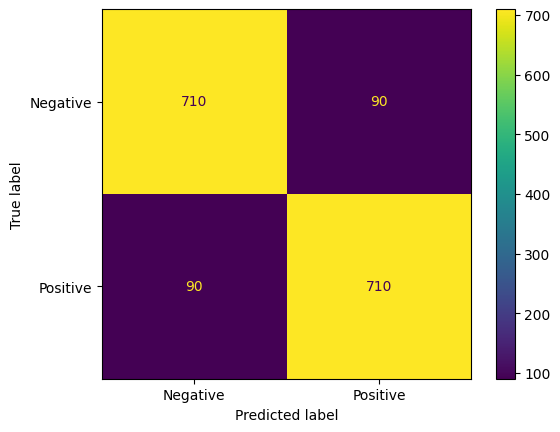

              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89       800
    Positive       0.89      0.89      0.89       800

    accuracy                           0.89      1600
   macro avg       0.89      0.89      0.89      1600
weighted avg       0.89      0.89      0.89      1600

Accuracy: 0.8875
Recall: 0.8875
Precision: 0.8875
F1-score: 0.8875


In [13]:
labels = ['Negative', 'Positive']

get_model_evaluation(y_true=testing_data['Label'], y_pred=model_predictions, labels=labels)